In [1]:
import os
import random
from collections import Counter
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
import time
warnings.filterwarnings("ignore")

In [2]:
# Set data directory
data_dir = 'asl-alphabet-dataset'
train_dir = os.path.join(data_dir, 'asl_alphabet_train')
test_dir = os.path.join(data_dir, 'asl_alphabet_test')

In [3]:
# Verify directories
print(f"Train dir exists: {os.path.exists(train_dir)}")
print(f"Test dir exists: {os.path.exists(test_dir)}")
if os.path.exists(train_dir):
    print(f"Train subdirs: {os.listdir(train_dir)}")
if os.path.exists(test_dir):
    print(f"Test files: {os.listdir(test_dir)}")

Train dir exists: True
Test dir exists: True
Train subdirs: ['Y', 'E', 'R', 'B', 'K', 'Z', 'nothing', 'M', 'S', 'D', 'W', 'Q', 'N', 'I', 'A', 'O', 'H', 'C', 'del', 'U', 'P', 'F', 'V', 'G', 'space', 'T', 'X', 'J', 'L']
Test files: ['Q_test.jpg', 'E_test.jpg', 'W_test.jpg', 'C_test.jpg', 'H_test.jpg', 'T_test.jpg', 'P_test.jpg', 'M_test.jpg', 'space_test.jpg', 'U_test.jpg', 'D_test.jpg', 'O_test.jpg', 'S_test.jpg', 'G_test.jpg', 'X_test.jpg', 'L_test.jpg', 'J_test.jpg', 'I_test.jpg', 'A_test.jpg', 'Z_test.jpg', 'B_test.jpg', 'V_test.jpg', 'Y_test.jpg', 'R_test.jpg', 'N_test.jpg', 'K_test.jpg', 'F_test.jpg', 'nothing_test.jpg']


In [4]:
# Classes
classes = sorted(os.listdir(train_dir))
num_classes = len(classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

Number of classes: 29
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [5]:
# EDA
train_counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in classes]
test_files = os.listdir(test_dir)
test_counts = {cls: 0 for cls in classes}
for file in test_files:
    if file.endswith('_test.jpg'):
        class_name = file.split('_test.jpg')[0]
        if class_name in classes:
            test_counts[class_name] += 1
test_counts_list = [test_counts[cls] for cls in classes]

df = pd.DataFrame({
    'class': classes + classes,
    'count': train_counts + test_counts_list,
    'split': ['train'] * num_classes + ['test'] * num_classes
})

df.head()

,class,count,split
0,A,3000,train
1,B,3000,train
2,C,3000,train
3,D,3000,train
4,E,3000,train


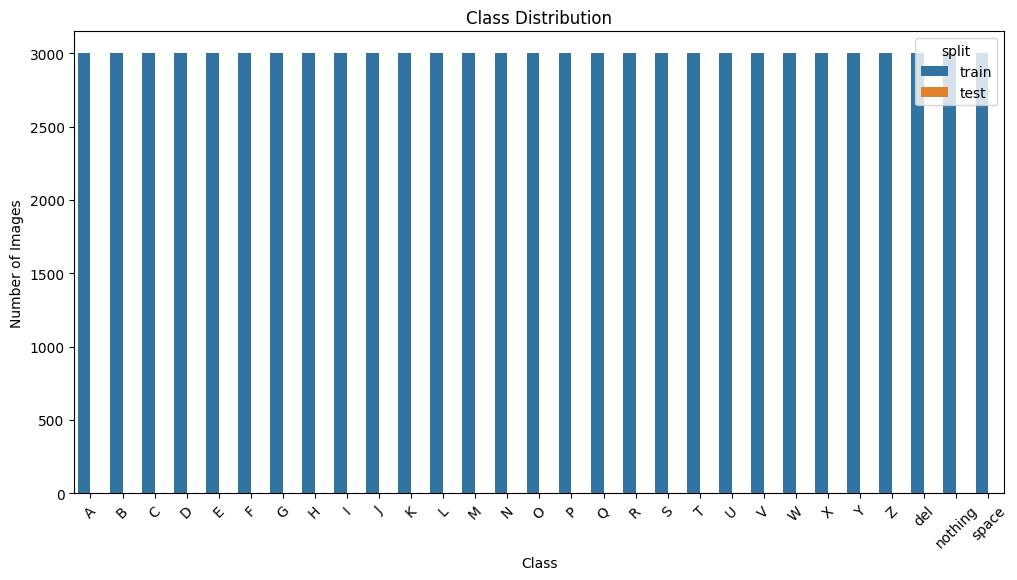

In [6]:
# Class distribution plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='class', y='count', hue='split')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.savefig('class_distribution.png')
plt.show()

In [7]:
# Statistics
train_mean = np.mean(train_counts)
test_mean = np.mean(test_counts_list)
print(f"Train set: Mean images per class: {train_mean:.2f}, Std: {np.std(train_counts):.2f}")
print(f"Test set: Mean images per class: {test_mean:.2f}, Std: {np.std(test_counts_list):.2f}")

Train set: Mean images per class: 3000.00, Std: 0.00
Test set: Mean images per class: 0.97, Std: 0.18


In [8]:
df.head()

,class,count,split
0,A,3000,train
1,B,3000,train
2,C,3000,train
3,D,3000,train
4,E,3000,train


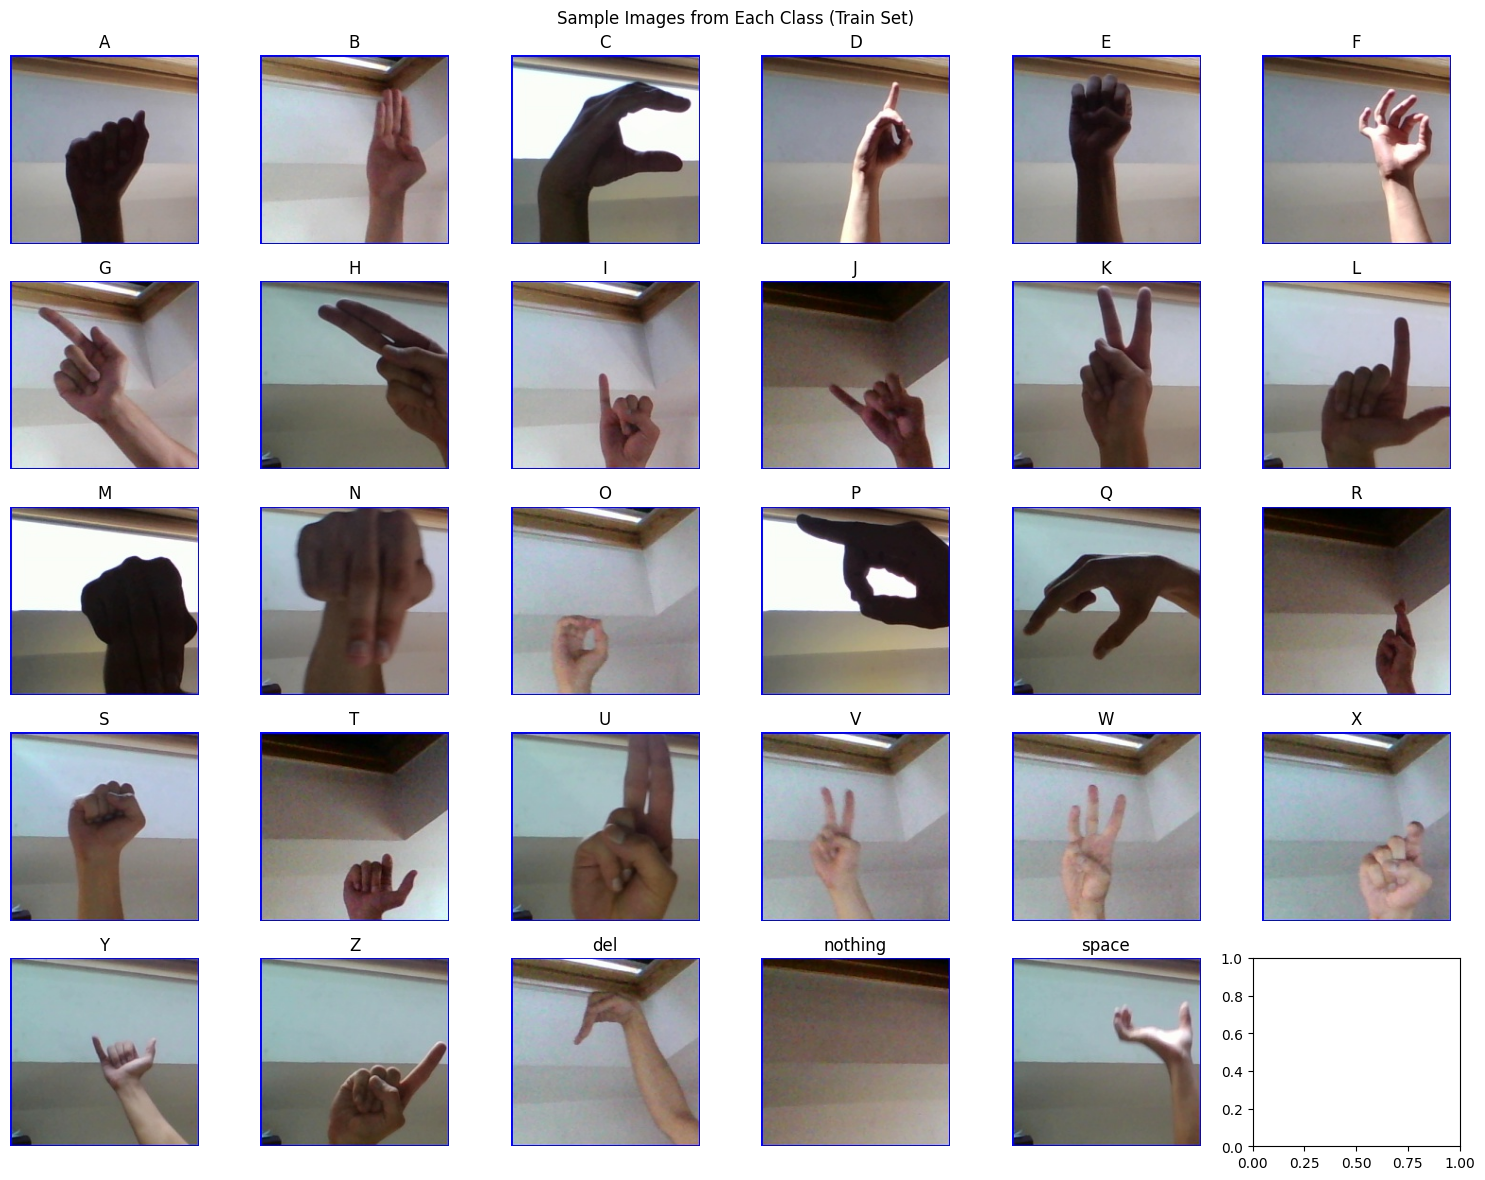

In [9]:
# Sample images
fig, axs = plt.subplots(5, 6, figsize=(15, 12))
axs = axs.flatten()
for i, cls in enumerate(classes):
    cls_dir = os.path.join(train_dir, cls)
    img_file = random.choice(os.listdir(cls_dir))
    img_path = os.path.join(cls_dir, img_file)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img)
        axs[i].set_title(cls)
        axs[i].axis('off')
plt.suptitle('Sample Images from Each Class (Train Set)')
plt.tight_layout()
plt.savefig('sample_images.png')
plt.show()

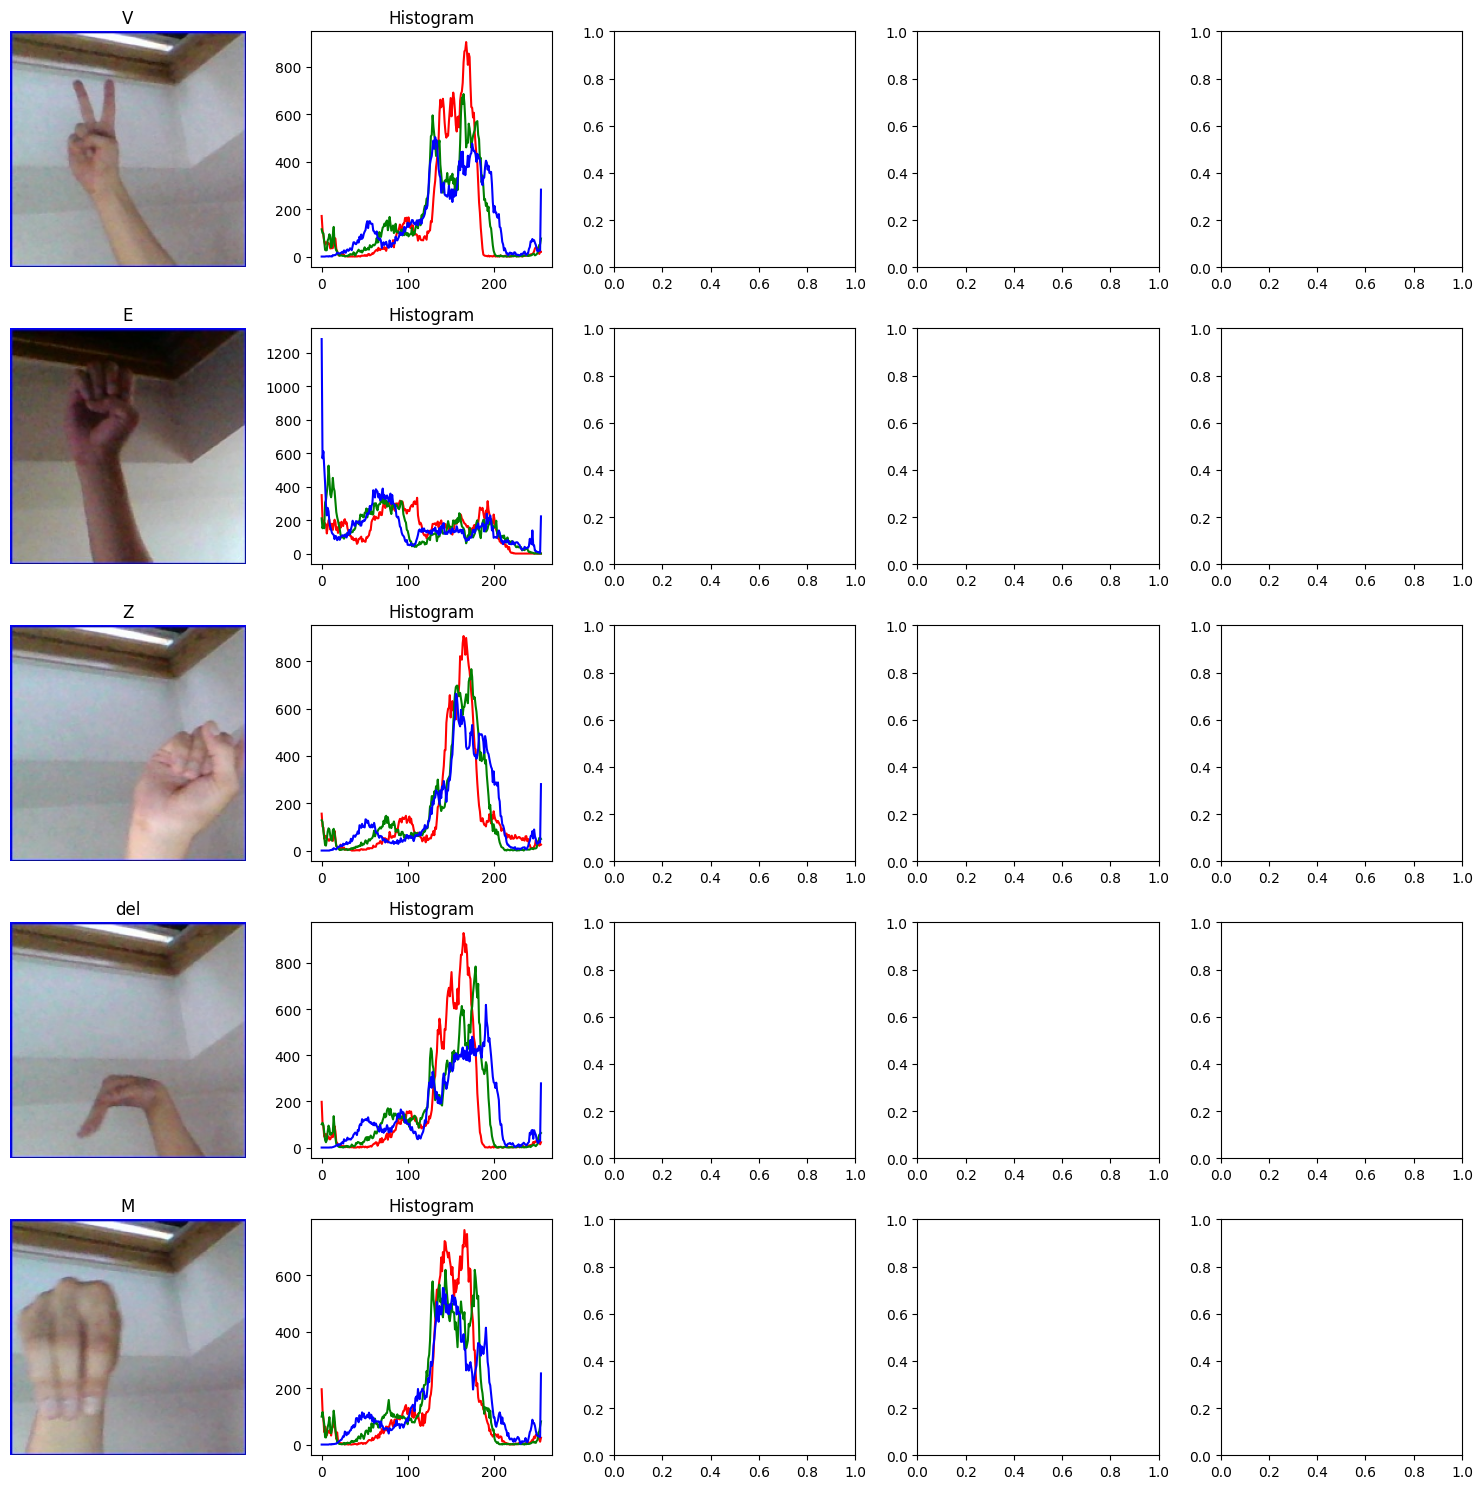

In [10]:
# Histogram for random classes
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
random_classes = random.sample(classes, 5)
for i, cls in enumerate(random_classes):
    cls_dir = os.path.join(train_dir, cls)
    img_file = random.choice(os.listdir(cls_dir))
    img_path = os.path.join(cls_dir, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(cls)
    axes[i, 0].axis('off')
    colors = ('r', 'g', 'b')
    for j, col in enumerate(colors):
        hist = cv2.calcHist([img], [j], None, [256], [0, 256])
        axes[i, 1].plot(hist, color=col)
    axes[i, 1].set_title('Histogram')
plt.tight_layout()
plt.savefig('histogram_images.png')
plt.show()

In [11]:
# Image details
sample_img_path = os.path.join(train_dir, classes[0], os.listdir(os.path.join(train_dir, classes[0]))[0])
img = cv2.imread(sample_img_path)
print(f"Sample image shape: {img.shape}, dtype: {img.dtype}")

Sample image shape: (200, 200, 3), dtype: uint8


Found 87000 files belonging to 29 classes.
Using 87000 files for training.
Range: 3000-3000 | Imbalance Ratio: 1.00
Balanced

Class Distribution:
A: 3000
B: 3000
C: 3000
D: 3000
E: 3000
F: 3000
G: 3000
H: 3000
I: 3000
J: 3000
K: 3000
L: 3000
M: 3000
N: 3000
O: 3000
P: 3000
Q: 3000
R: 3000
S: 3000
T: 3000
U: 3000
V: 3000
W: 3000
X: 3000
Y: 3000
Z: 3000
del: 3000
nothing: 3000
space: 3000


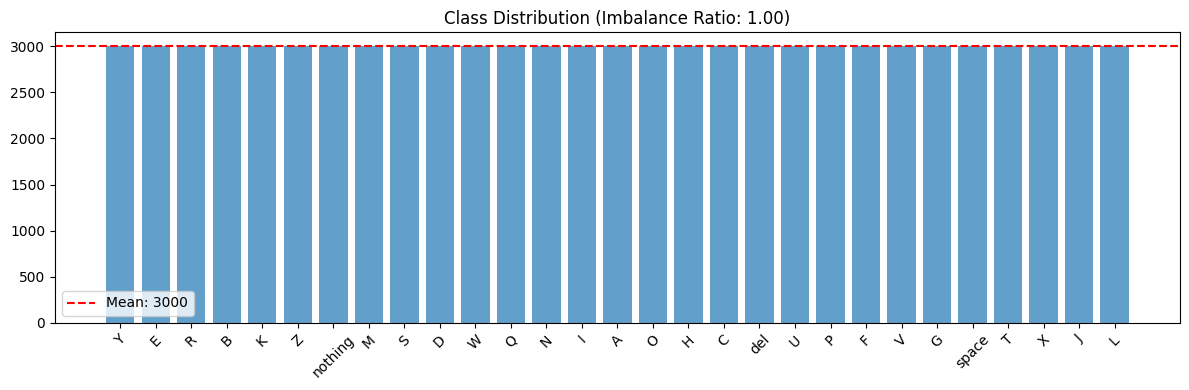

{'Y': 3000,
 'E': 3000,
 'R': 3000,
 'B': 3000,
 'K': 3000,
 'Z': 3000,
 'nothing': 3000,
 'M': 3000,
 'S': 3000,
 'D': 3000,
 'W': 3000,
 'Q': 3000,
 'N': 3000,
 'I': 3000,
 'A': 3000,
 'O': 3000,
 'H': 3000,
 'C': 3000,
 'del': 3000,
 'U': 3000,
 'P': 3000,
 'F': 3000,
 'V': 3000,
 'G': 3000,
 'space': 3000,
 'T': 3000,
 'X': 3000,
 'J': 3000,
 'L': 3000}

In [12]:
# Balance check
def check_balance(dataset_dir):
    class_counts = {folder: len([f for f in os.listdir(os.path.join(dataset_dir, folder))
                                 if f.endswith(('.jpg', '.png', '.jpeg'))])
                    for folder in os.listdir(dataset_dir)
                    if os.path.isdir(os.path.join(dataset_dir, folder))}
    vals = list(class_counts.values())
    total_samples, num_classes = sum(vals), len(vals)
    min_samples, max_samples, mean_samples = min(vals), max(vals), sum(vals)/len(vals)
    imbalance_ratio = max_samples / min_samples
    print(f"Found {total_samples} files belonging to {num_classes} classes.")
    print(f"Using {total_samples} files for training.")
    print(f"Range: {min_samples}-{max_samples} | Imbalance Ratio: {imbalance_ratio:.2f}")
    print("Balanced" if imbalance_ratio <= 1.5 else "Imbalanced" if imbalance_ratio <= 3 else "Severely Imbalanced")
    print("\nClass Distribution:")
    for class_name, count in sorted(class_counts.items()):
        print(f"{class_name}: {count}")
    plt.figure(figsize=(12, 4))
    plt.bar(class_counts.keys(), class_counts.values(), alpha=0.7)
    plt.axhline(y=mean_samples, color='red', linestyle='--', label=f'Mean: {mean_samples:.0f}')
    plt.title(f'Class Distribution (Imbalance Ratio: {imbalance_ratio:.2f})')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig('class_distribution_balance.png')
    plt.show()
    return class_counts

check_balance(train_dir)

In [13]:
# EDA Report
eda_report = f"""
EDA Report:
- Structure: Train subfolders per class, Test flat <class>_test.jpg.
- Classes: {num_classes} ({', '.join(classes)}).
- Train: ~{train_mean:.0f} images per class, balanced (std: {np.std(train_counts):.2f}).
- Test: ~{test_mean:.0f} images per class.
- Images: 200x200 RGB, dtype: {img.dtype}.
- Challenges: Small test set (~{sum(test_counts_list)} images); rely on validation for evaluation.
"""
with open('eda_report.txt', 'w') as f:
    f.write(eda_report)
print(eda_report)


EDA Report:
- Structure: Train subfolders per class, Test flat <class>_test.jpg.
- Classes: 29 (A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z, del, nothing, space).
- Train: ~3000 images per class, balanced (std: 0.00).
- Test: ~1 images per class.
- Images: 200x200 RGB, dtype: uint8.
- Challenges: Small test set (~28 images); rely on validation for evaluation.



In [14]:
img_size = (64, 64)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,   # split training set into 80/20
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


In [15]:
# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [16]:
# Normalization & augmentation
normalization_layer = tf.keras.layers.Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
])

In [17]:
# Apply scaling + augmentation
train_ds = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x)), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [18]:
# Optimize performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
print("Train batches:", len(train_ds))
print("Validation batches:", len(val_ds))

Train batches: 2175
Validation batches: 544


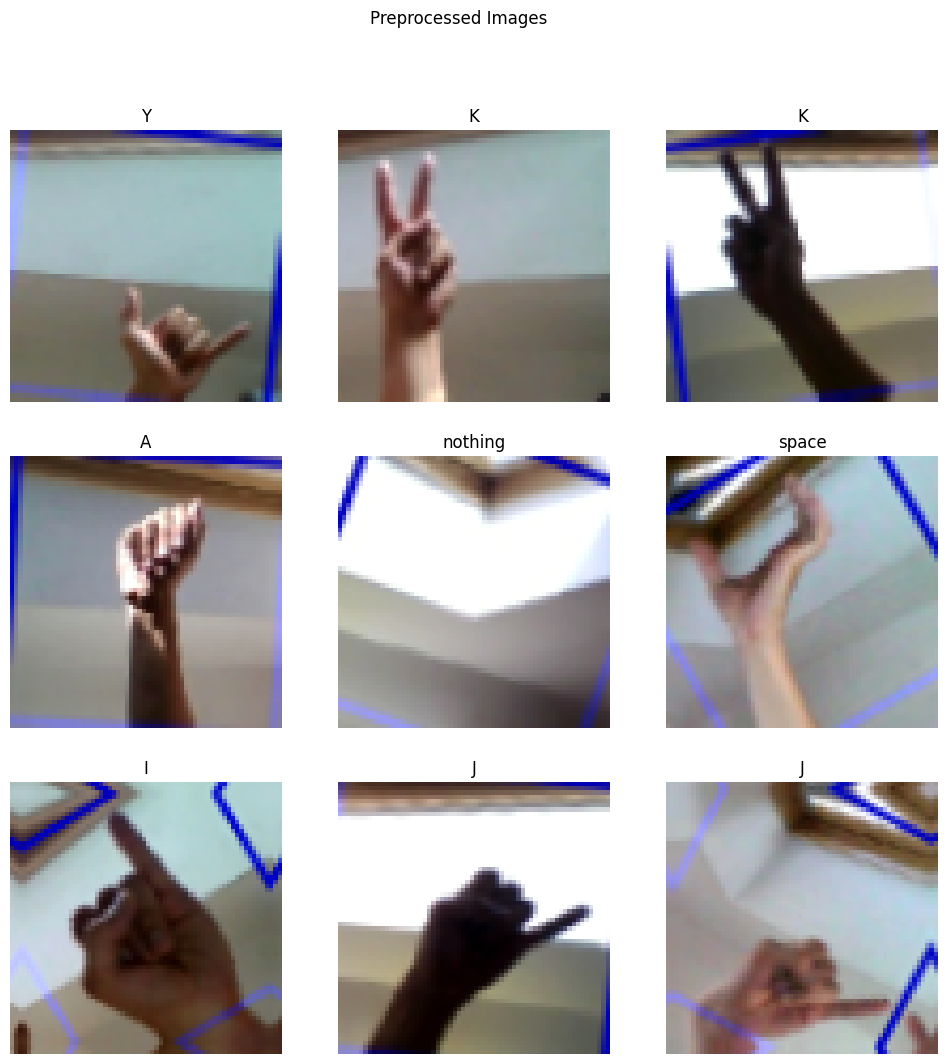

In [20]:
# Visualize preprocessed images
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy())
    plt.title(classes[int(label_batch[i].numpy())])
    plt.axis("off")
plt.suptitle("Preprocessed Images")
plt.savefig('preprocessed_images.png')
plt.show()

In [21]:
# Data Augmentation Pipeline
pipeline_doc = f"""
Data Augmentation Pipeline:
- Resize to {img_size[0]}x{img_size[1]}.
- Normalization: Rescale to [0,1].
- Train augmentations: Horizontal flip (50%), rotation (±10%), zoom (±10%), contrast (±20%).
"""
with open('augmentation_pipeline.txt', 'w') as f:
    f.write(pipeline_doc)
print(pipeline_doc)


Data Augmentation Pipeline:
- Resize to 64x64.
- Normalization: Rescale to [0,1].
- Train augmentations: Horizontal flip (50%), rotation (±10%), zoom (±10%), contrast (±20%).



In [22]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])


In [23]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [24]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 712s 300ms/step - accuracy: 0.3241 - loss: 2.2871 - val_accuracy: 0.7636 - val_loss: 0.6928
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 596s 259ms/step - accuracy: 0.8157 - loss: 0.5520 - val_accuracy: 0.9190 - val_loss: 0.2499
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 569s 262ms/step - accuracy: 0.9088 - loss: 0.2716 - val_accuracy: 0.9236 - val_loss: 0.2168
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 628s 265ms/step - accuracy: 0.9425 - loss: 0.1683 - val_accuracy: 0.9389 - val_loss: 0.1836
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 614s 261ms/step - accuracy: 0.9603 - loss: 0.1176 - val_accuracy: 0.9275 - val_loss: 0.2324
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 614s 257ms/step - accuracy: 0.9638 - loss: 0.1069 - val_accuracy: 0.9630 - val_loss: 0.1142
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 560s 258ms/step - accuracy: 0.9725 - loss: 0.0828 - val_accuracy: 0.9678 - val_loss: 0.1056
Epoch 8/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 561s 258ms/step - ac

In [25]:
loss, acc = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

544/544 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.9613 - loss: 0.1202
Validation Loss: 0.1266
Validation Accuracy: 0.9609


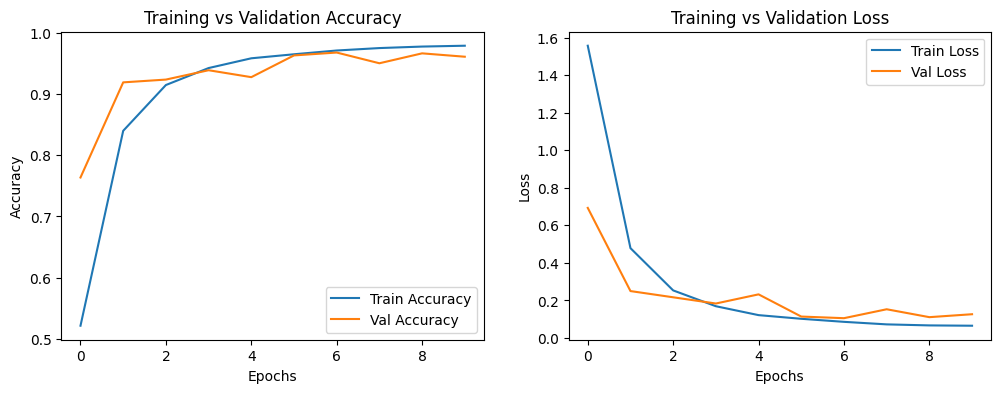

In [26]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()

In [27]:
#Saving the model as .h5
model.save("cnn_model.h5")

In [28]:
# Collect all jpg file paths
test_image_paths = [os.path.join(test_dir, fname)
                    for fname in os.listdir(test_dir) if fname.endswith(".jpg")]

# Extract labels from filenames (before "_test.jpg")
test_labels = [os.path.basename(p).split("_")[0] for p in test_image_paths]

print("Sample filenames:", test_image_paths[:])
print("Extracted labels:", test_labels[:])

Sample filenames: ['asl-alphabet-dataset/asl_alphabet_test/Q_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/E_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/W_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/C_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/H_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/T_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/P_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/M_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/space_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/U_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/D_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/O_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/S_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/G_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/X_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/L_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/J_test.jpg', 'asl-alphabet-dataset/asl_alphabet_test/I_test.jpg', 'asl-alphabet-dataset/a

In [29]:
# Map labels to integers
unique_labels = sorted(set(test_labels))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

y_test_true = np.array([label_to_index[label] for label in test_labels])

print("Label mapping:", label_to_index)
print("True labels shape:", y_test_true.shape)

Label mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'nothing': 26, 'space': 27}
True labels shape: (28,)


In [30]:
def load_and_preprocess_with_label(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    return img, label

# Build dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, y_test_true))
test_ds = test_ds.map(load_and_preprocess_with_label, num_parallel_calls=AUTOTUNE)

# Apply your preprocessing
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE).batch(batch_size)

In [31]:
y_test_pred = model.predict(test_ds)
y_test_pred_classes = y_test_pred.argmax(axis=1)
print("Test Accuracy:", accuracy_score(y_test_true, y_test_pred_classes))
print("\nClassification Report:\n", classification_report(y_test_true, y_test_pred_classes))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Test Accuracy: 0.8928571428571429

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00    

In [32]:
acc = accuracy_score(y_test_true, y_test_pred_classes)
print(f"Accuracy: {acc:.2%}")
print(f"Correct predictions: {int(acc * len(y_test_true))}/{len(y_test_true)}")

Accuracy: 89.29%
Correct predictions: 25/28


In [33]:
!ls -l /content

total 1082136
drwxr-xr-x 4 root root       4096 Sep 30 16:22 asl-alphabet-dataset
-rw-r--r-- 1 root root 1097580026 Sep  5 12:01 asl-alphabet-dataset.zip
-rw-r--r-- 1 root root        179 Oct  1 00:03 augmentation_pipeline.txt
-rw-r--r-- 1 root root      31358 Oct  1 00:02 class_distribution_balance.png
-rw-r--r-- 1 root root      30119 Oct  1 00:01 class_distribution.png
-rw-r--r-- 1 root root    8289488 Oct  1 01:44 cnn_model.h5
-rw-r--r-- 1 root root        396 Oct  1 00:02 eda_report.txt
-rw-r--r-- 1 root root     600649 Oct  1 00:02 histogram_images.png
-rw-r--r-- 1 root root         69 Sep 30 16:20 kaggle.json
-rw-r--r-- 1 root root     123434 Oct  1 00:03 preprocessed_images.png
drwxr-xr-x 1 root root       4096 Sep 26 13:40 sample_data
-rw-r--r-- 1 root root    1414060 Oct  1 00:01 sample_images.png


In [34]:
from google.colab import files
files.download('/content/cnn_model.h5')
files.download('/content/eda_report.txt')
files.download('/content/augmentation_pipeline.txt')
files.download('/content/class_distribution.png')
files.download('/content/sample_images.png')
files.download('/content/histogram_images.png')
files.download('/content/class_distribution_balance.png')
files.download('/content/preprocessed_images.png')
files.download('/content/kaggle.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>